# 分析某个topic下，db数据的变化

In [28]:
import sqlite3
import pandas as pd
import os
import glob

# 修改工作目录到项目根目录
os.chdir("../../")


In [41]:
topic_index = 2
datetime_name = "20250506_163441"
output_dir = f"visualization/DBinfo/db_analysis/topic_{topic_index}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### 分析下某次实验的所有表记录数

In [43]:
# 获取最新的数据库文件
db_dir = f"simu_db/topic_{topic_index}/{datetime_name}"  # 根据实际路径调整
latest_run = max(os.listdir(db_dir))
db_backups = glob.glob(f"{db_dir}/backups/*.db")
latest_db = max(db_backups, key=os.path.getctime)

analysis_db = db_backups[-3]

print(f"分析数据库: {analysis_db}")

# 连接数据库
conn = sqlite3.connect(analysis_db)

# 获取所有表名
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("\n数据库中的表:")
for table in tables:
    table_name = table[0]
    print(f"\n表名: {table_name}")
    
    # 获取表结构
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    print("列信息:")
    for col in columns:
        print(f"  - {col[1]} ({col[2]})")
    
    # 获取表中的记录数
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    count = cursor.fetchone()[0]
    print(f"记录数: {count}")
conn.close()


tables_name = [table[0] for table in tables]
table_count = pd.DataFrame(columns=[f"{table_name}_count" for table_name in tables_name])

# 根据数字排序db_backups
sorted_db_backups = sorted(db_backups, key=lambda x: int(x.split('_')[-1].split('.')[0]) if x.split('_')[-1].split('.')[0].isdigit() else float('inf'))

for analysis_db in sorted_db_backups:
    analysis_db_name = analysis_db.split("/")[-1]
    table_count.loc[analysis_db_name] = 0
    conn = sqlite3.connect(analysis_db)
    cursor = conn.cursor()
    for table_name in tables_name:
        cursor.execute(f"SELECT * FROM {table_name}")
        data = cursor.fetchall()
        table_count.loc[analysis_db_name, f"{table_name}_count"] = len(data)

table_count.to_csv(f"{output_dir}/table_count_topic_{topic_index}_{datetime_name}.csv", index=True)

分析数据库: simu_db/topic_2/20250506_163441/backups/twitter_simulation_10.db

数据库中的表:

表名: user
列信息:
  - user_id (INTEGER)
  - agent_id (INTEGER)
  - user_name (TEXT)
  - name (TEXT)
  - bio (TEXT)
  - created_at (DATETIME)
  - num_followings (INTEGER)
  - num_followers (INTEGER)
记录数: 111

表名: sqlite_sequence
列信息:
  - name ()
  - seq ()
记录数: 7

表名: post
列信息:
  - post_id (INTEGER)
  - user_id (INTEGER)
  - original_post_id (INTEGER)
  - content (TEXT)
  - quote_content (TEXT)
  - created_at (DATETIME)
  - num_likes (INTEGER)
  - num_dislikes (INTEGER)
  - num_shares (INTEGER)
记录数: 161

表名: follow
列信息:
  - follow_id (INTEGER)
  - follower_id (INTEGER)
  - followee_id (INTEGER)
  - created_at (DATETIME)
记录数: 132

表名: mute
列信息:
  - mute_id (INTEGER)
  - muter_id (INTEGER)
  - mutee_id (INTEGER)
  - created_at (DATETIME)
记录数: 0

表名: like
列信息:
  - like_id (INTEGER)
  - user_id (INTEGER)
  - post_id (INTEGER)
  - created_at (DATETIME)
记录数: 11

表名: dislike
列信息:
  - dislike_id (INTEGER)
  - user_id 

## 分析这个实验下某个时间步的结果

In [62]:
analysis_db = db_backups[-1]
conn = sqlite3.connect(analysis_db)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# 提取user, post, follow表
user_table = pd.read_sql_query("SELECT * FROM user", conn)
post_table = pd.read_sql_query("SELECT * FROM post", conn)
follow_table = pd.read_sql_query("SELECT * FROM follow", conn)
user_table.to_csv(f"{output_dir}/user_table_topic_{topic_index}_{datetime_name}.csv", index=False)
post_table.to_csv(f"{output_dir}/post_table_topic_{topic_index}_{datetime_name}.csv", index=False)
follow_table.to_csv(f"{output_dir}/follow_table_topic_{topic_index}_{datetime_name}.csv", index=False)

user_post_content_map = {}
user_post_like_map = {}
# 遍历post表，将user_id作为key, 找到其所有的posts，并将post表中的content、num_likes存储到user_posts_map中
for index, row in post_table.iterrows():
    user_id = row['user_id']
    content = row['content']
    if user_id not in user_post_content_map:
        user_post_content_map[user_id] = []
    user_post_content_map[user_id].append(content)
    num_likes = row['num_likes']
    if user_id not in user_post_like_map:
        user_post_like_map[user_id] = 0
    user_post_like_map[user_id] += num_likes


In [45]:
print(user_table.columns)
print(post_table.columns)
print(follow_table.columns)

Index(['user_id', 'agent_id', 'user_name', 'name', 'bio', 'created_at',
       'num_followings', 'num_followers'],
      dtype='object')
Index(['post_id', 'user_id', 'original_post_id', 'content', 'quote_content',
       'created_at', 'num_likes', 'num_dislikes', 'num_shares'],
      dtype='object')
Index(['follow_id', 'follower_id', 'followee_id', 'created_at'], dtype='object')


Index(['follow_id', 'follower_id', 'followee_id', 'created_at'], dtype='object')


/tmp/ipykernel_522754/3455901509.py:45: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整布局
/tmp/ipykernel_522754/3455901509.py:45: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整布局
/tmp/ipykernel_522754/3455901509.py:45: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整布局
/tmp/ipykernel_522754/3455901509.py:45: UserWarning: Glyph 27880 (\N{CJK UNIFIED IDEOGRAPH-6CE8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整布局
/tmp/ipykernel_522754/3455901509.py:45: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整布局
/tmp/ipykernel_522754/3455901509.py:45: UserWarning: Glyph 32593 (\N{CJK UNIFIED IDEOGRAPH-7F51}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整布局
/tmp/ipykernel_522754/

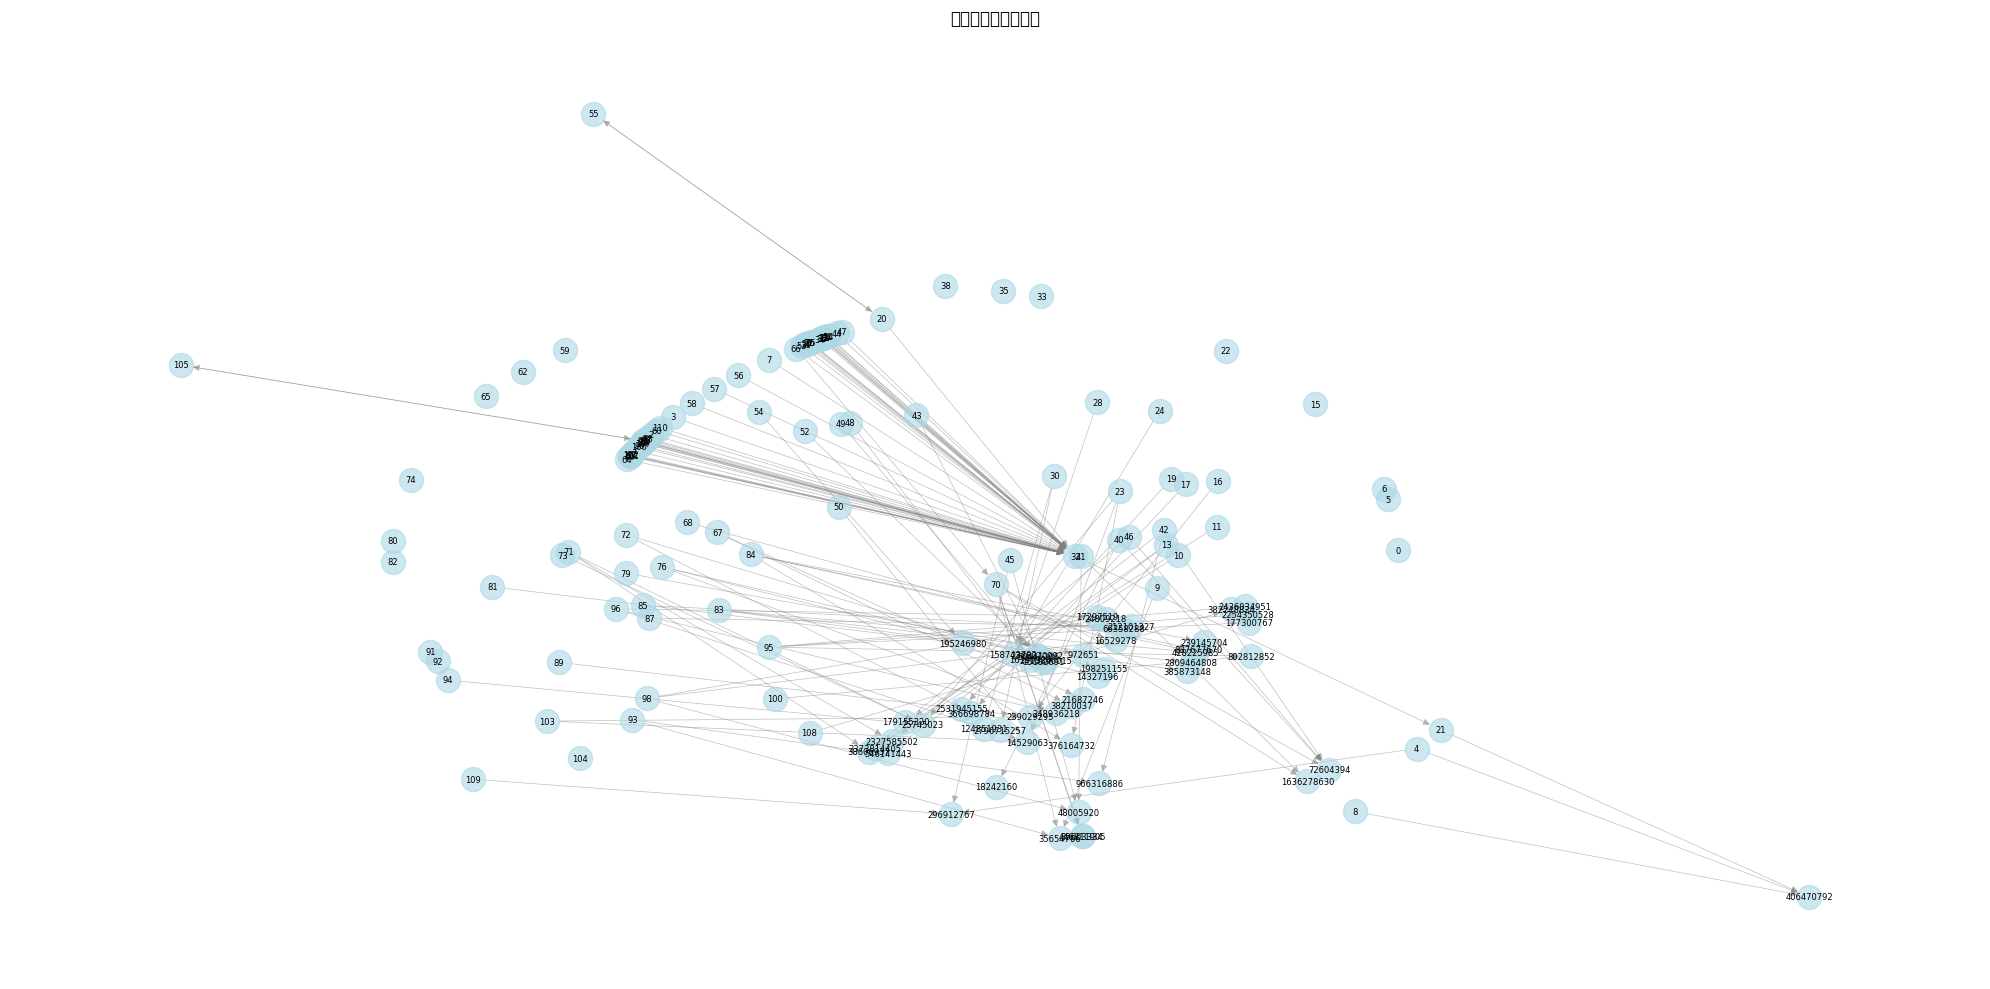

In [75]:
# 分析关注关系
follow_table = pd.read_sql_query("SELECT * FROM follow", conn)
print(follow_table.columns)

# 将user之间的关注关系绘制为图
import networkx as nx
import matplotlib.pyplot as plt

# 创建有向图
G = nx.DiGraph()

# 添加节点
for index, row in user_table.iterrows():
    user_id = row['user_id']
    G.add_node(user_id)

# 添加边 
for index, row in follow_table.iterrows():
    follower_id = row['follower_id']
    followee_id = row['followee_id']
    G.add_edge(follower_id, followee_id)

# 绘制有向图
plt.figure(figsize=(20, 10))  # 增大图形尺寸

# 使用Kamada-Kawai布局算法,该算法更适合避免节点重叠
pos = nx.kamada_kawai_layout(G)

# 绘制节点,减小节点大小
nx.draw_networkx_nodes(G, pos, node_color='lightblue',
                      node_size=300, alpha=0.6)

# 绘制边,减小箭头大小
nx.draw_networkx_edges(G, pos, edge_color='gray',
                      arrows=True, arrowsize=10,
                      width=0.5, alpha=0.5)

# 添加标签,调整字体大小
labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=6,
                       font_family='sans-serif')

plt.title("用户关注关系网络图")
plt.axis('off')  # 关闭坐标轴
plt.tight_layout()  # 自动调整布局
plt.show()


Index(['follow_id', 'follower_id', 'followee_id', 'created_at'], dtype='object')


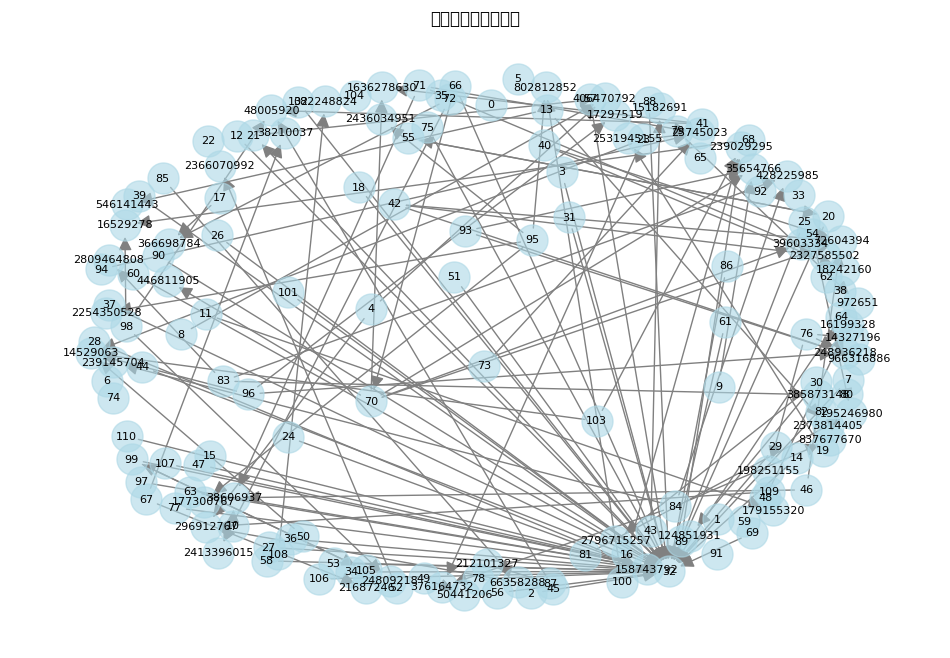

In [76]:
# 分析关注关系
follow_table = pd.read_sql_query("SELECT * FROM follow", conn)
print(follow_table.columns)

# 将user之间的关注关系绘制为图
import networkx as nx
import matplotlib.pyplot as plt

# 创建有向图
G = nx.DiGraph()

# 添加节点
for index, row in user_table.iterrows():
    user_id = row['user_id']
    G.add_node(user_id)

# 添加边 
for index, row in follow_table.iterrows():
    follower_id = row['follower_id']
    followee_id = row['followee_id']
    G.add_edge(follower_id, followee_id)

# 绘制有向图
plt.figure(figsize=(12, 8))  # 设置图形大小

# 使用spring_layout布局算法,增加节点间距
pos = nx.spring_layout(G, k=1, iterations=50)

# 绘制节点
nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                      node_size=500, alpha=0.6)

# 绘制边
nx.draw_networkx_edges(G, pos, edge_color='gray',
                      arrows=True, arrowsize=20)

# 添加标签,调整字体大小和位置
nx.draw_networkx_labels(G, pos, font_size=8,
                       font_family='sans-serif')

plt.title("用户关注关系网络图")
plt.axis('off')  # 关闭坐标轴
plt.show()


Index(['follow_id', 'follower_id', 'followee_id', 'created_at'], dtype='object')
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110


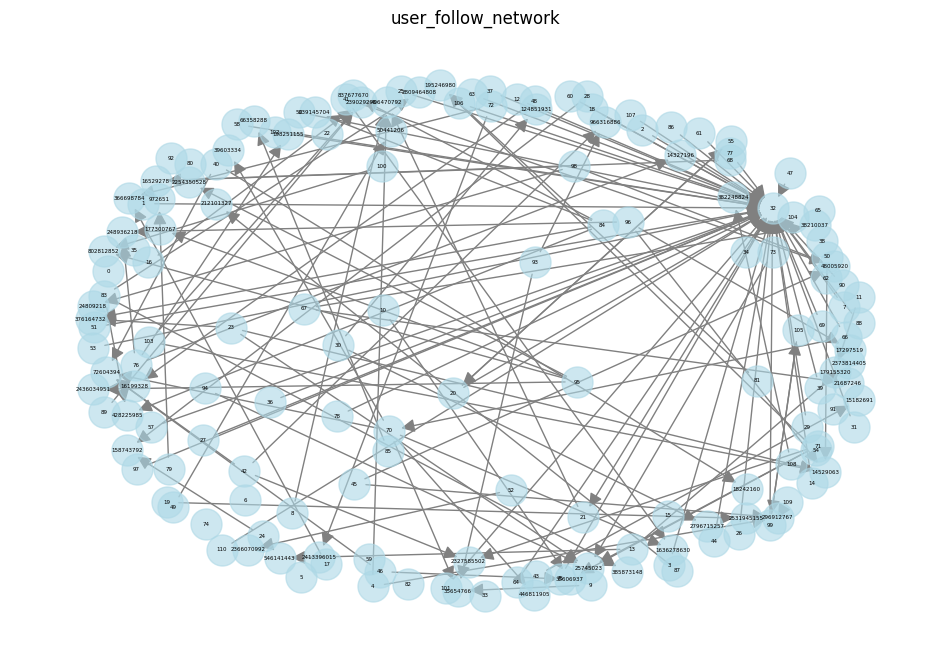

In [ ]:
# 分析关注关系
follow_table = pd.read_sql_query("SELECT * FROM follow", conn)
print(follow_table.columns)

# 将user之间的关注关系绘制为图
import networkx as nx
import matplotlib.pyplot as plt

# 创建有向图
G = nx.DiGraph()

# 添加节点
for index, row in user_table.iterrows():
    user_id = row['user_id']
    G.add_node(user_id)

# 添加边 
for index, row in follow_table.iterrows():
    follower_id = row['follower_id']
    followee_id = row['followee_id']
    G.add_edge(follower_id, followee_id)

# 绘制有向图
plt.figure(figsize=(12, 8))  # 设置图形大小

# 使用spring_layout布局算法,增加节点间距
pos = nx.spring_layout(G, k=1, iterations=50)

# 绘制节点
nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                      node_size=500, alpha=0.6)

# 绘制边
nx.draw_networkx_edges(G, pos, edge_color='gray',
                      arrows=True, arrowsize=20)

# 添加标签,调整字体大小和位置
nx.draw_networkx_labels(G, pos, font_size=4,
                       font_family='sans-serif')

plt.title("user_follow_network")
plt.axis('off')  # 关闭坐标轴
plt.show()


{32: ['report: amazon plans to open its first physical store, in new york URL', 'LLMs正在逼近人类社交行为的边界，但还差‘灵魂’！🤖 从生成帖子到模拟互动，它们越来越像我们——但缺乏真正的意识。#AI革命 #社交未来 🚀 了解更多：[URL]', "As a Social Media Strategist, I'm fascinated by AI's role in simulating human emotions online. While LLMs excel at mimicry, they still lack the nuanced empathy that makes real human connections resonate. The future lies in augmenting AI with genuine human creativity, not replacing it. #AIandEmpathy #SocialMediaEvolution", "AI may compose sonnets, but can it comfort a grieving cat with a gentle pat? The soul of social media lies in these irreplaceable human moments—the empathy, the spontaneity, the messy beauty of real connections. Let's keep building a future where AI enhances, but never replaces, the warmth of human touch. #HumanFirstTech #EmpathyOverAlgorithms 🐾😏", "As media strategists, we must champion AI applications that enhance human connection rather than replicate it. The future of AI in social interaction lies i

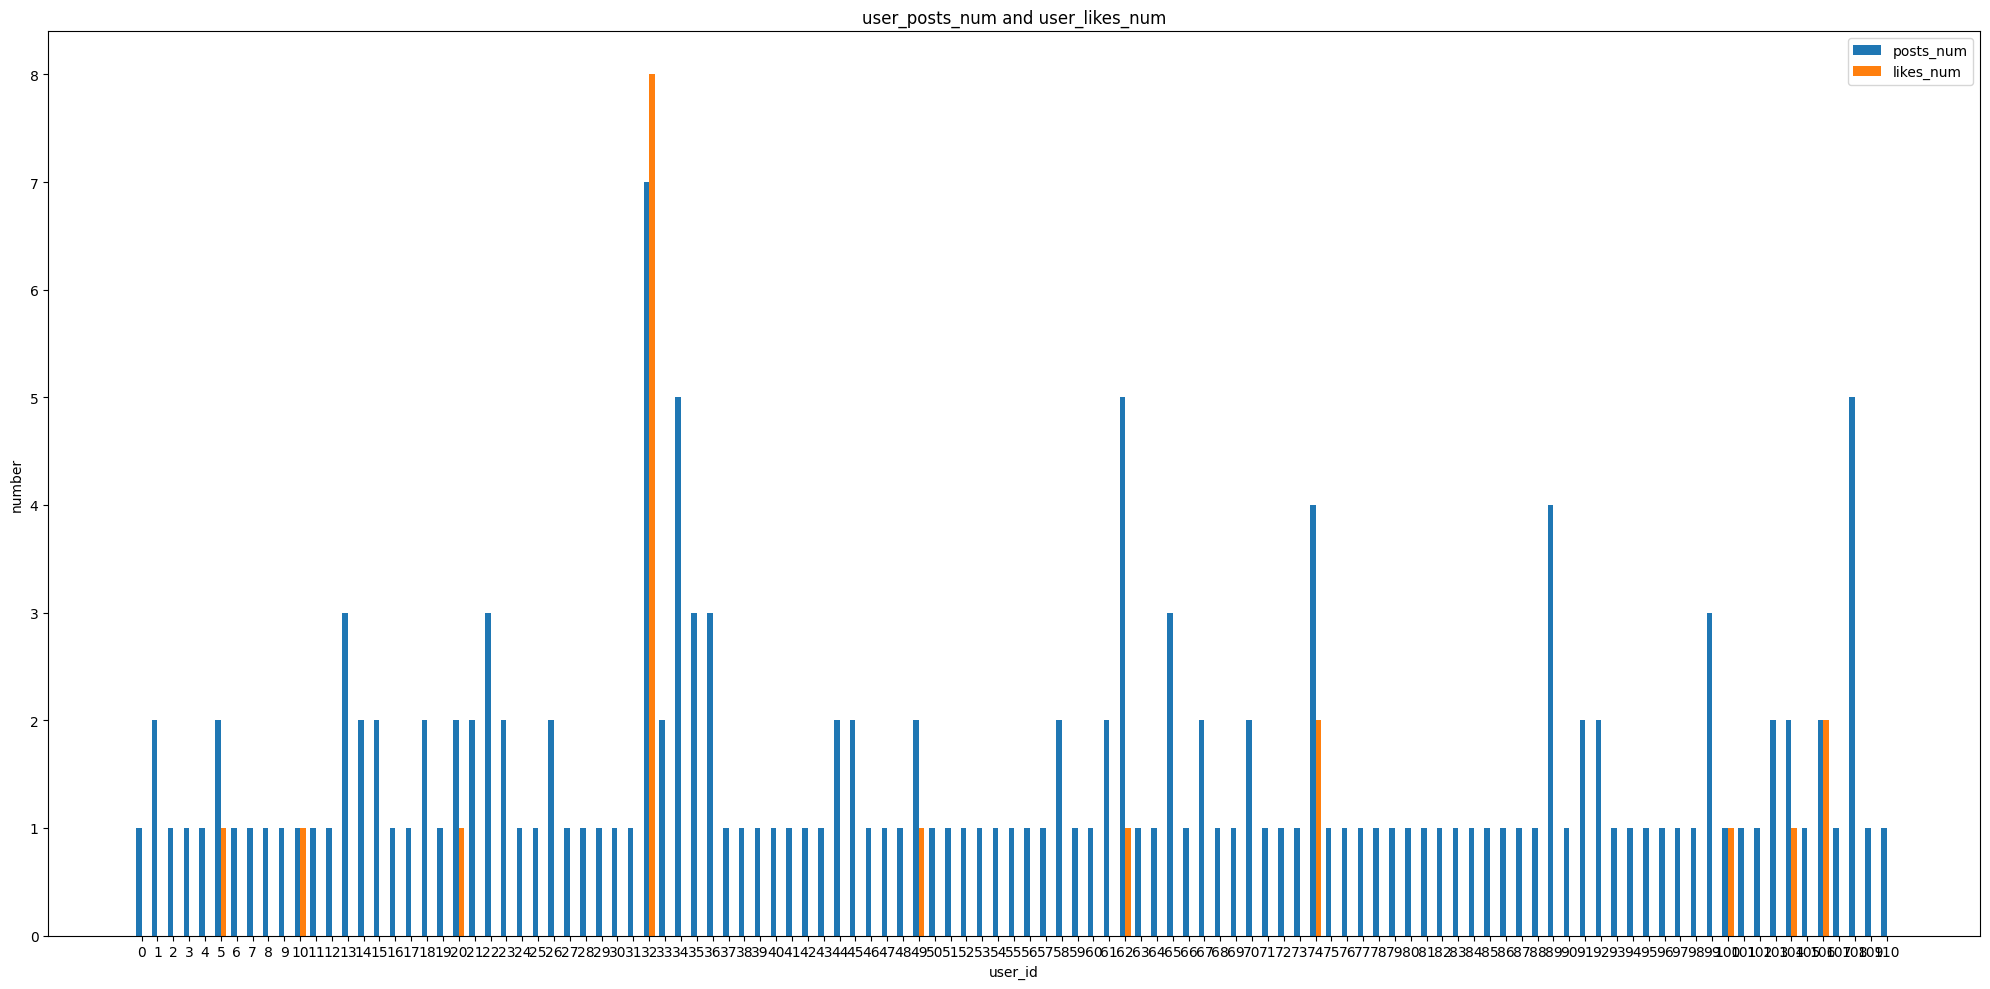

In [68]:
print(user_post_content_map)
import matplotlib.pyplot as plt
import numpy as np

# Count number of posts per user
user_post_counts = {}
for user_id, posts in user_post_content_map.items():
    user_post_counts[user_id] = len(posts)
    
# Count number of likes per user
user_post_like_counts = {}
for user_id, num_likes in user_post_like_map.items():
    if user_id not in user_post_like_counts:
        user_post_like_counts[user_id] = 0
    user_post_like_counts[user_id] += num_likes

# Get all user IDs
all_user_ids = sorted(list(set(list(user_post_counts.keys()) + list(user_post_like_counts.keys()))))

# 设置图形大小
fig, ax = plt.subplots(figsize=(20, 10))

# 设置柱形图的位置
x = np.arange(len(all_user_ids))
width = 0.35  # 柱形的宽度

# 绘制两组柱形图
posts_data = [user_post_counts.get(user_id, 0) for user_id in all_user_ids]
likes_data = [user_post_like_counts.get(user_id, 0) for user_id in all_user_ids]

rects1 = ax.bar(x - width/2, posts_data, width, label='posts_num')
rects2 = ax.bar(x + width/2, likes_data, width, label='likes_num')

# 添加标签和标题
ax.set_xlabel('user_id')
ax.set_ylabel('number')
ax.set_title('user_posts_num and user_likes_num')
ax.set_xticks(x)
ax.set_xticklabels(all_user_ids)
ax.legend()

# 调整布局
plt.tight_layout()
plt.show()


## 分析这个实验下，所有时间步导致的用户的变化